In [1]:
import fitz
from pathlib import Path
import random

import pandas as pd 
import numpy as np

from tqdm.autonotebook import tqdm, trange

import torch

/var/folders/ft/r3rwscxj6bxgq3r7vv3pf6340000gn/T/ipykernel_46853/1377141249.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
pdf_path = Path('./Early Iran History.pdf')
doc = fitz.open(pdf_path)

In [3]:
page_content = {}
for page_number, page in enumerate(doc) :
    text = page.get_text().replace('\n', ' ')
    page_content[page_number+1] = text

In [4]:
data = pd.DataFrame(columns=['page_number', 'text'])
data['page_number'] = list(page_content.keys())
data['text'] = list(page_content.values())

In [5]:
data.apply(
    lambda row: [
        len(row['text']),            # char count
        len(row['text'].split()),    # word count
        len(row['text'].split('. ')) # sentence count
    ],
    axis=1,
)

0          [57, 19, 1]
1         [282, 60, 1]
2         [250, 37, 2]
3         [262, 86, 3]
4           [28, 4, 1]
            ...       
273    [1770, 301, 15]
274     [1657, 263, 3]
275     [1672, 276, 8]
276    [1649, 278, 15]
277     [1351, 225, 7]
Length: 278, dtype: object

In [6]:

data[['char_count', 'word_count', 'sentence_count']] = data.apply(
    lambda row: [
        len(row['text']),            # char count
        len(row['text'].split()),    # word count
        len(row['text'].split('. ')) # sentence count
    ],
    axis=1,
    result_type='expand',
)

In [7]:
data['token_count'] = data['char_count'] / 4 # assuming 4 chars per token

In [8]:
data

,page_number,text,char_count,word_count,sentence_count,token_count
0,1,H I S T O R Y O F E A R L Y I R A N oi.uc...,57,19,1,14.25
1,2,T H E U N I V E R S I T Y O F C H I C A G O...,282,60,1,70.50
2,3,HISTORY OF EARLY IRAN BY GEORGE G. CAMERON I...,250,37,2,62.50
3,4,C O P Y R I G H T I 9 3 6 B Y T H E U N I ...,262,86,3,65.50
4,5,TO MY WIFE oi.uchicago.edu,28,4,1,7.00
...,...,...,...,...,...,...
273,274,"256 HISTORY OF EARLY IRAN Sikris, c., 151 f....",1770,301,15,442.50
274,275,"INDEX Susa, c.—Continued pottery of, 8-10 r...",1657,263,3,414.25
275,276,"258 HISTORY OF EARLY IRAN Tetep-mada, p.y 80...",1672,276,8,418.00
276,277,"INDEX 259 Umhuluma, p. y 199, 204 Umma, c....",1649,278,15,412.25


In [9]:
data.describe()

,page_number,char_count,word_count,sentence_count,token_count
count,278.000000,278.000000,278.000000,278.000000,278.000000
mean,139.500000,1552.615108,254.305755,17.050360,388.153777
std,80.395895,353.851760,61.606033,8.775848,88.462940
min,1.000000,16.000000,1.000000,1.000000,4.000000
25%,70.250000,1524.250000,249.000000,12.000000,381.062500
50%,139.500000,1615.500000,265.000000,16.000000,403.875000
75%,208.750000,1718.750000,284.000000,21.000000,429.687500
max,278.000000,2386.000000,396.000000,78.000000,596.500000


<Axes: ylabel='Frequency'>

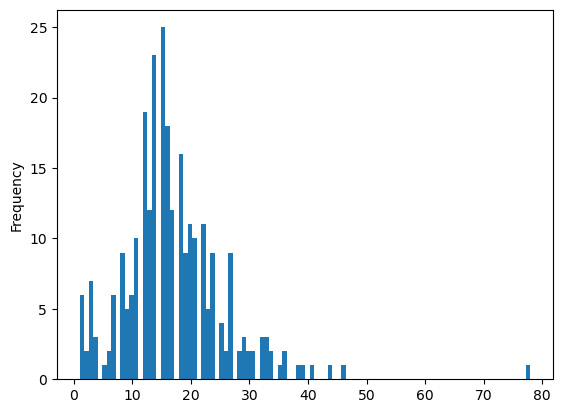

In [10]:
data['sentence_count'].plot(kind='hist', bins=100)

<Axes: ylabel='Frequency'>

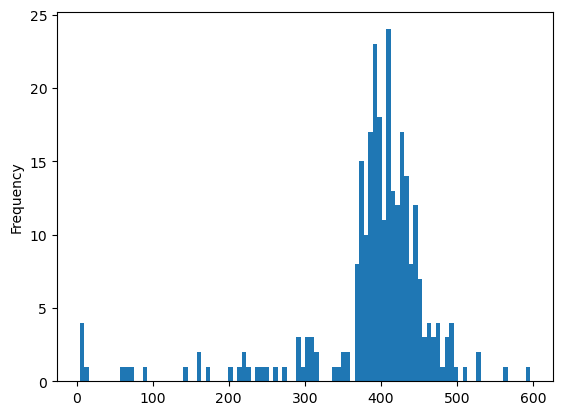

In [11]:
data['token_count'].plot(kind='hist', bins=100)

___

In [12]:
# import os
# os.environ['HF_HOME'] = '~/huggingface_cache'
# os.environ['TRANSFORMERS_CACHE'] = '~/huggingface_cache'

### splitting pages into sentences

In [13]:
from spacy.lang.en import English 

In [14]:
nlp = English()
nlp.add_pipe("sentencizer")

In [15]:
data['sentences'] = data.apply(
    func=lambda row: list(nlp(row['text']).sents),
    axis=1,
    # result_type='expand'
)

# make sure all the sentences are str() (if you don't do this , the type will be )
data['sentences'] = data['sentences'].map(
    lambda sentences: list(map(lambda s: s.text, sentences))
)

In [16]:
sample = data.sample()
sample

,page_number,text,char_count,word_count,sentence_count,token_count,sentences
30,31,THE LAND AND ITS PEOPLE and the later Lycians...,1970,286,21,492.5,[THE LAND AND ITS PEOPLE and the later Lycian...


In [17]:
data.describe().round(2)

,page_number,char_count,word_count,sentence_count,token_count
count,278.00,278.00,278.00,278.00,278.00
mean,139.50,1552.62,254.31,17.05,388.15
std,80.40,353.85,61.61,8.78,88.46
min,1.00,16.00,1.00,1.00,4.00
25%,70.25,1524.25,249.00,12.00,381.06
50%,139.50,1615.50,265.00,16.00,403.88
75%,208.75,1718.75,284.00,21.00,429.69
max,278.00,2386.00,396.00,78.00,596.50


### Chunking our sentences together

Note that the model we are going to use for embedding has a context size of 384 tokens.

In [18]:
data

,page_number,text,char_count,word_count,sentence_count,token_count,sentences
0,1,H I S T O R Y O F E A R L Y I R A N oi.uc...,57,19,1,14.25,[H I S T O R Y O F E A R L Y I R A N oi.u...
1,2,T H E U N I V E R S I T Y O F C H I C A G O...,282,60,1,70.50,[T H E U N I V E R S I T Y O F C H I C A G ...
2,3,HISTORY OF EARLY IRAN BY GEORGE G. CAMERON I...,250,37,2,62.50,[HISTORY OF EARLY IRAN BY GEORGE G. CAMERON ...
3,4,C O P Y R I G H T I 9 3 6 B Y T H E U N I ...,262,86,3,65.50,[C O P Y R I G H T I 9 3 6 B Y T H E U N I...
4,5,TO MY WIFE oi.uchicago.edu,28,4,1,7.00,[TO MY WIFE oi.uchicago.edu]
...,...,...,...,...,...,...,...
273,274,"256 HISTORY OF EARLY IRAN Sikris, c., 151 f....",1770,301,15,442.50,"[256 HISTORY OF EARLY IRAN Sikris, c., 151 f..."
274,275,"INDEX Susa, c.—Continued pottery of, 8-10 r...",1657,263,3,414.25,"[INDEX Susa, c.—Continued pottery of, 8-10 ..."
275,276,"258 HISTORY OF EARLY IRAN Tetep-mada, p.y 80...",1672,276,8,418.00,"[258 HISTORY OF EARLY IRAN Tetep-mada, p.y 8..."
276,277,"INDEX 259 Umhuluma, p. y 199, 204 Umma, c....",1649,278,15,412.25,"[INDEX 259 Umhuluma, p. y 199, 204 Umma, c..."


In [19]:
data.describe()

,page_number,char_count,word_count,sentence_count,token_count
count,278.000000,278.000000,278.000000,278.000000,278.000000
mean,139.500000,1552.615108,254.305755,17.050360,388.153777
std,80.395895,353.851760,61.606033,8.775848,88.462940
min,1.000000,16.000000,1.000000,1.000000,4.000000
25%,70.250000,1524.250000,249.000000,12.000000,381.062500
50%,139.500000,1615.500000,265.000000,16.000000,403.875000
75%,208.750000,1718.750000,284.000000,21.000000,429.687500
max,278.000000,2386.000000,396.000000,78.000000,596.500000


In [20]:
data['sentences'].apply(func=lambda s: len(s)).mean()

15.633093525179856

In [21]:
data['sentences'].apply(func=lambda s: len(s)).median()

15.0

<Axes: ylabel='Frequency'>

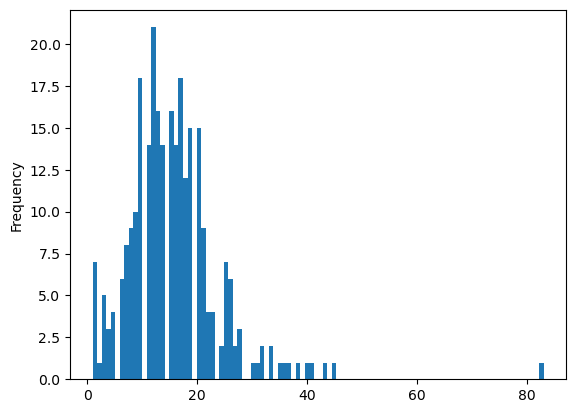

In [22]:
data['sentences'].apply(func=lambda s: len(s)).plot(kind='hist', bins=100)

Let's put 10 sentences in each chunk, this can lower the input token size of the model, and also has other benefits

#### Choosing the chunk_size

In [23]:
data.describe()

,page_number,char_count,word_count,sentence_count,token_count
count,278.000000,278.000000,278.000000,278.000000,278.000000
mean,139.500000,1552.615108,254.305755,17.050360,388.153777
std,80.395895,353.851760,61.606033,8.775848,88.462940
min,1.000000,16.000000,1.000000,1.000000,4.000000
25%,70.250000,1524.250000,249.000000,12.000000,381.062500
50%,139.500000,1615.500000,265.000000,16.000000,403.875000
75%,208.750000,1718.750000,284.000000,21.000000,429.687500
max,278.000000,2386.000000,396.000000,78.000000,596.500000


on average, each page has 17 sentences  
on average, each page has 388 tokens  
approximately, each sentence has `(388/17) = 23` tokens  

colored markdown 
<span style="color:red">**TODO:** </span>  
**Find the appropriate chunk size for our model.**

In [24]:
# 384 is the token size of the embedeer model we are going to use
384 // 23 

16

### Chunk the data

In [25]:
chunk_size = 13

In [26]:
def get_chunk_points(chunk_size, array_length):
    return list(
        range(chunk_size, array_length + 1, chunk_size)
    )

In [27]:
data['chunked'] = data.apply(
    func=lambda row: np.split(
        row['sentences'],
        get_chunk_points(chunk_size, len(row['sentences']))
    ),
    axis=1
)

___

Analyze the pages after chunking it 

In [28]:
data['chunked'].apply(func=lambda chunks: len(chunks)).mean() # on average, each page has 1.7 chunks

1.7410071942446044

<Axes: ylabel='Frequency'>

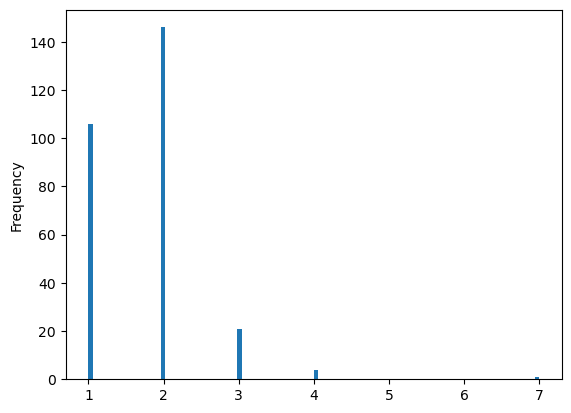

In [29]:
data['chunked'].apply(func=lambda chunks: len(chunks)).plot(kind='hist', bins=100) # distribution of chunks per page

### Splitting each chunk into its own item

In [30]:
chunked_data = data.explode('chunked').reset_index()

In [31]:
chunked_data.where(
    chunked_data['page_number'] == 13
).dropna()

,index,page_number,text,char_count,word_count,sentence_count,token_count,sentences,chunked
12,12.0,13.0,ABBREVIATIONS AJSL American Journal of Semit...,988.0,135.0,27.0,247.0,[ABBREVIATIONS AJSL American Journal of Semi...,[ABBREVIATIONS AJSL American Journal of Semi...
13,12.0,13.0,ABBREVIATIONS AJSL American Journal of Semit...,988.0,135.0,27.0,247.0,[ABBREVIATIONS AJSL American Journal of Semi...,"[D: Researches and Treatises., Ed., by H. V. ..."
14,12.0,13.0,ABBREVIATIONS AJSL American Journal of Semit...,988.0,135.0,27.0,247.0,[ABBREVIATIONS AJSL American Journal of Semi...,[]


This shows that the the page 13 has been split into 3 chunks, since it had 27 sentences, now it is chunked to 13, 13 , 1 sentences

organize the `chunked_data`

In [32]:
chunked_data = chunked_data[['page_number', 'chunked']]

# converting the chunked list into one string
chunked_data['chunked'] = chunked_data['chunked'].apply(
    func=lambda chunk: ' '.join(chunk)
)

# let's also calculate the chunk toke_size for each chunk
chunked_data['token_count'] = chunked_data.apply(
    func=lambda chunk: len(chunk['chunked'])/4,
    axis=1
)
chunked_data.head()

,page_number,chunked,token_count
0,1,H I S T O R Y O F E A R L Y I R A N oi.uc...,14.00
1,2,T H E U N I V E R S I T Y O F C H I C A G O...,70.25
2,3,HISTORY OF EARLY IRAN BY GEORGE G. CAMERON I...,62.25
3,4,C O P Y R I G H T I 9 3 6 B Y T H E U N I ...,65.25
4,5,TO MY WIFE oi.uchicago.edu,6.75


In [36]:
chunked_data.describe()

,page_number,token_count
count,484.000000,484.000000
mean,133.971074,222.747934
std,74.221810,168.051920
min,1.000000,0.000000
25%,73.750000,44.000000
50%,129.500000,295.500000
75%,195.250000,381.062500
max,278.000000,470.000000


Some chunks have too little token_count, let's check it

In [47]:
chunked_data[chunked_data['token_count'] < 44].dropna().head(10)

,page_number,chunked,token_count
0,1,H I S T O R Y O F E A R L Y I R A N oi.uc...,14.00
4,5,TO MY WIFE oi.uchicago.edu,6.75
5,6,oi.uchicago.edu,3.75
11,12,oi.uchicago.edu,3.75
14,13,,0.00
17,14,,0.00
22,16,,0.00
30,23,1-30. oi.uchicago.edu,5.50
34,25,37 and 43. oi.uchicago.edu,6.75
50,34,oi.uchicago.edu,4.00


Many of them are short and unimportant text, we can drop them.

In [48]:
chunked_data = chunked_data[chunked_data['token_count'] > 44]

In [49]:
chunked_data.describe()

,page_number,token_count
count,361.000000,361.000000
mean,133.487535,293.342105
std,76.234656,134.769753
min,2.000000,44.250000
25%,69.000000,141.750000
50%,127.000000,360.500000
75%,196.000000,392.250000
max,278.000000,470.000000


Much Better :))

___

### Embedding text chunks